# <font color='purple'>Preprocessing QC statistics </font> 
## Sagy, Feb 2024


In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
import os
MOMAPS_HOME = '/home/labs/hornsteinlab/Collaboration/MOmaps'
MOMAPS_DATA_HOME = '/home/labs/hornsteinlab/Collaboration/MOmaps'
LOGS_PATH = os.path.join(MOMAPS_DATA_HOME, "outputs/preprocessing/spd/logs/preprocessing_FUS/fixing_untreated")
PLOT_PATH = os.path.join(MOMAPS_DATA_HOME, "outputs/preprocessing/spd/logs/preprocessing_FUS/plots")
os.chdir(MOMAPS_HOME)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["image.cmap"] = "Set1"
from src.common.lib.preprocessing_utils import rescale_intensity
from src.common.lib.images_qc import *
import contextlib
import io
import matplotlib
import warnings
warnings.filterwarnings('ignore', category=pd.core.common.SettingWithCopyWarning)
from src.common.lib.qc_config_tmp import *
from src.common.lib.image_sampling_utils import *
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
pd.__version__

In [17]:
df = log_files_qc(LOGS_PATH,only_wt_cond=False)
df_dapi = df[df.marker=='DAPI']
df_target = df[df.marker!='DAPI']

reading logs of batch1_Untreated

Total of 1 files were read.
Before dup handeling  (16668, 22)
After duplication removal #1: (16668, 23)
After duplication removal #2: (9050, 23)


In [23]:
# choose batches
# batches = [f'batch{i}' for i in range(2,6)]
batches = ['batch1']
batches

['batch1']

### Raw Files Validation

1. How many site **tiff** files do we have in each folder?
2. Are all existing files valid? (tif, at least 2049kB, not corrupetd)

batch1_Untreated
Folder structure is invalid. Missing paths:
/home/labs/hornsteinlab/Collaboration/MOmaps/input/images/raw/SpinningDisk/FUS_lines_stress_2024_sorted/batch1_Untreated/KOLF
/home/labs/hornsteinlab/Collaboration/MOmaps/input/images/raw/SpinningDisk/FUS_lines_stress_2024_sorted/batch1_Untreated/FUSRevertant
/home/labs/hornsteinlab/Collaboration/MOmaps/input/images/raw/SpinningDisk/FUS_lines_stress_2024_sorted/batch1_Untreated/FUSHeterozygous
No bad files are found.
Total Sites:  0


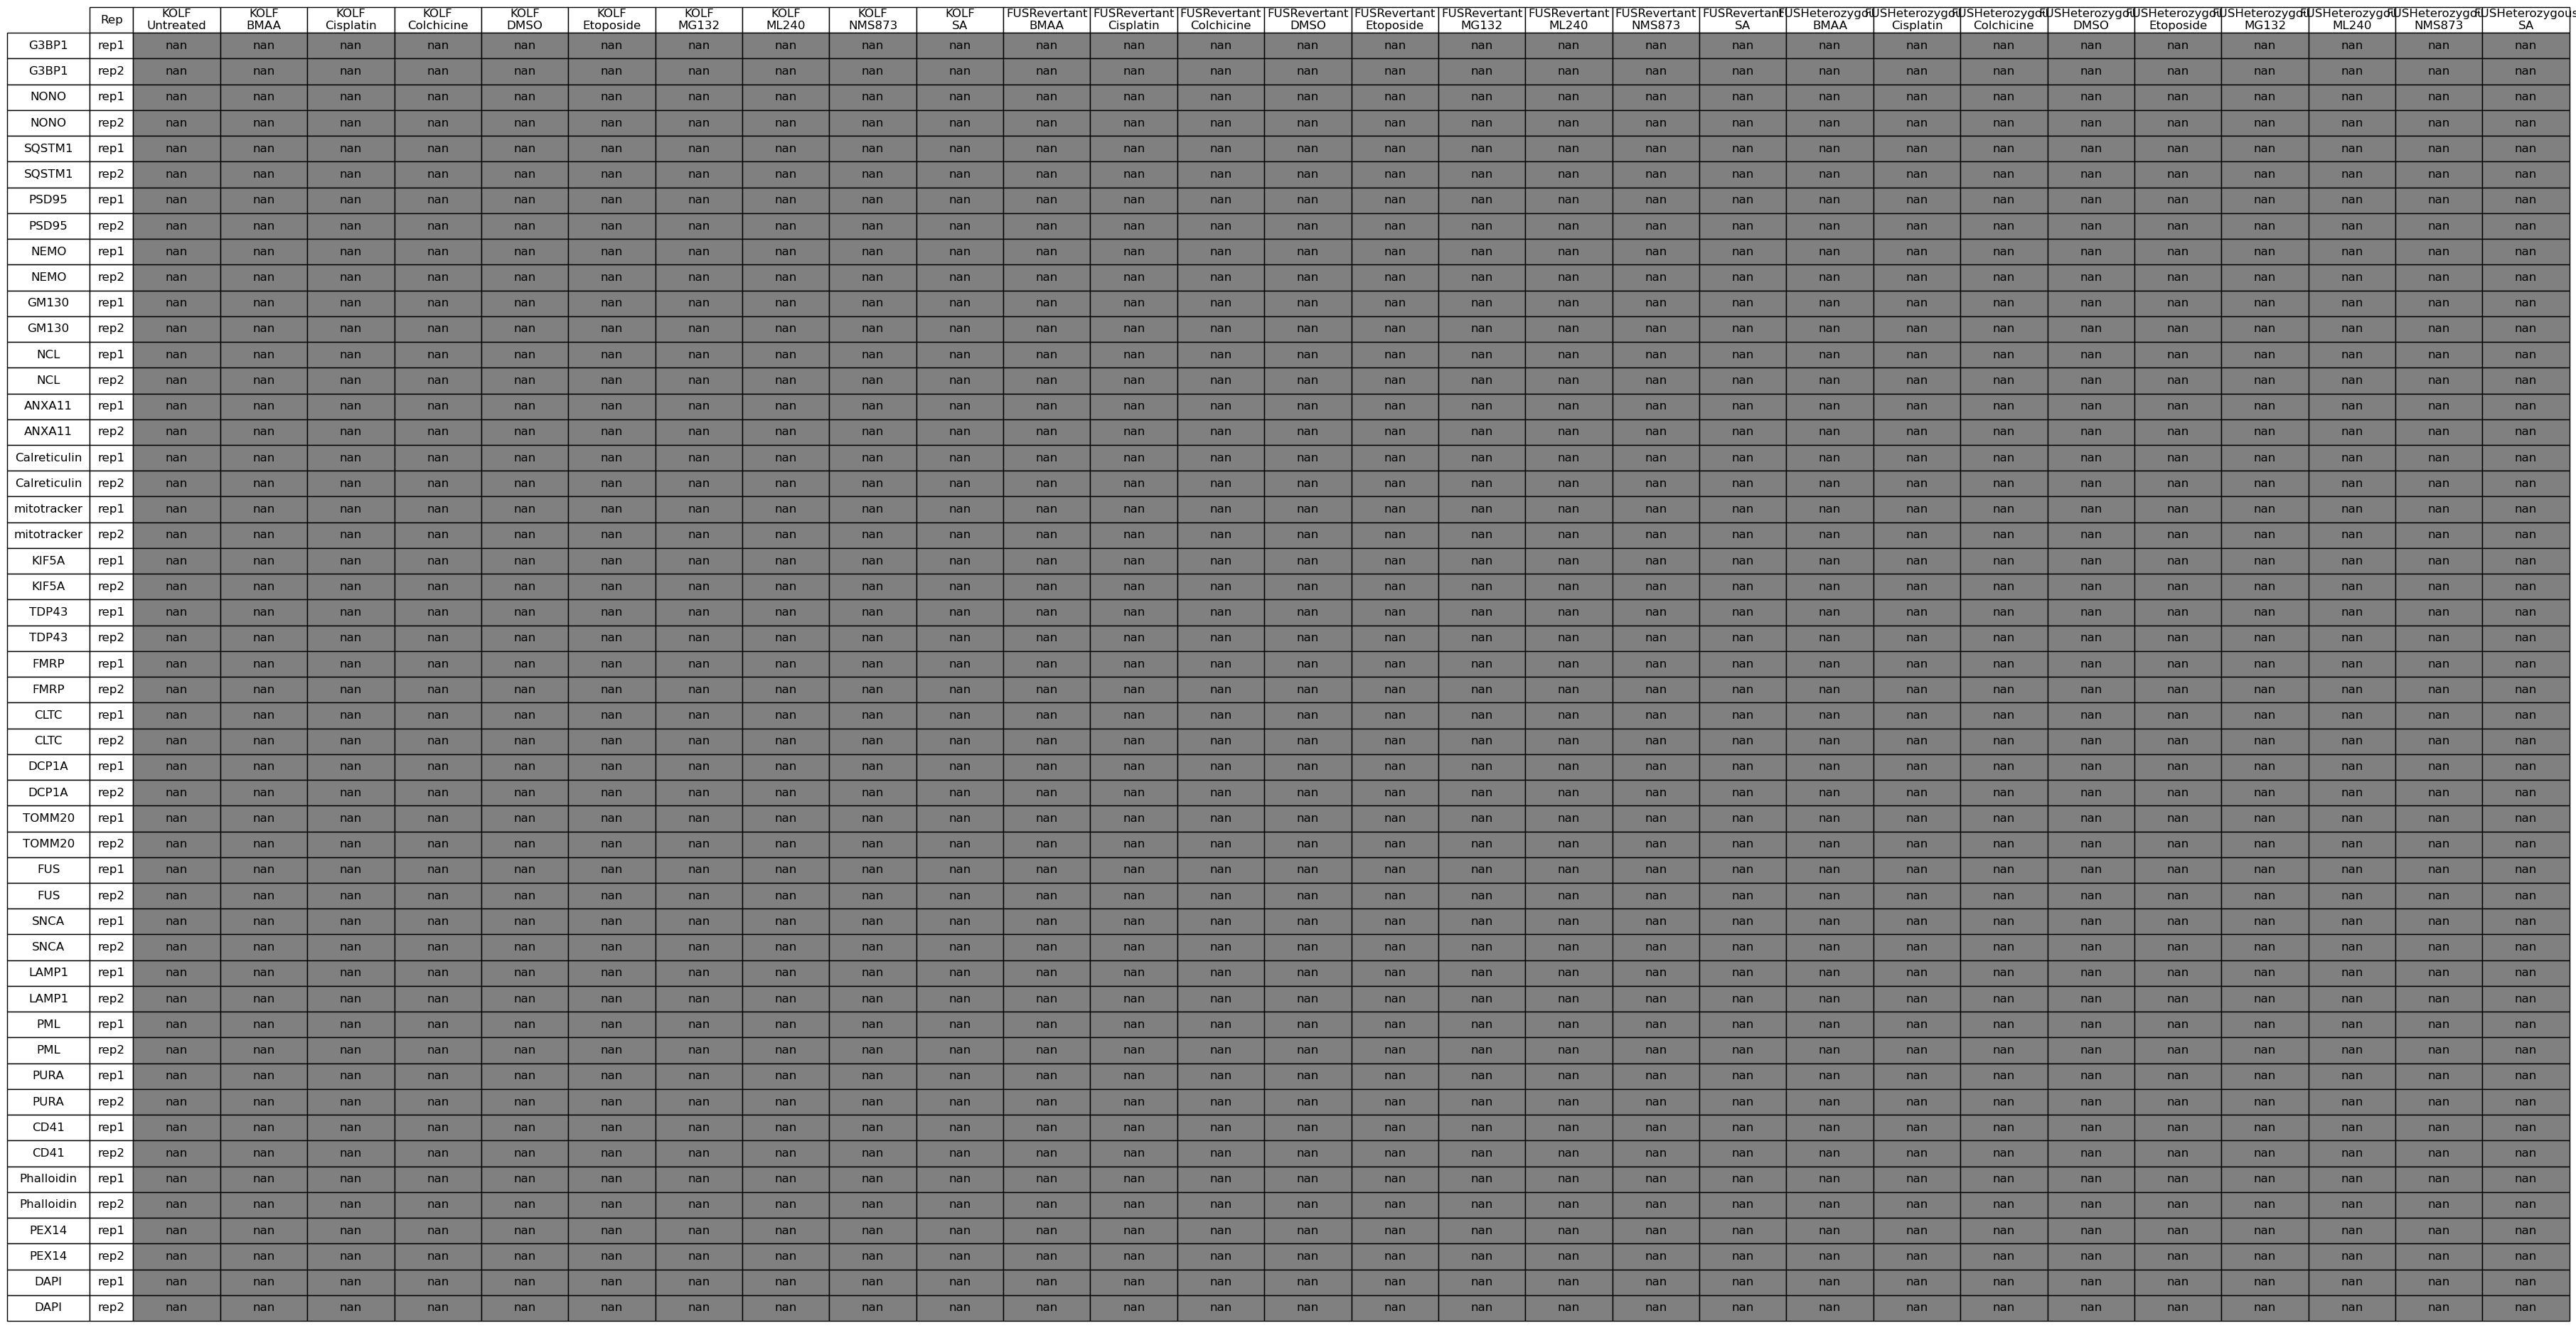

In [5]:

root_directory_raw = os.path.join(MOMAPS_DATA_HOME, 'input', 'images', 'raw', 'SpinningDisk','FUS_lines_stress_2024_sorted')

batches_raw = [batch.replace("_16bit_no_downsample","") for batch in batches]
raws = run_validate_folder_structure(root_directory_raw, False, fus_panels, fus_markers.copy(),PLOT_PATH, fus_marker_info,
                                    fus_cell_lines_to_cond, reps, fus_cell_lines_for_disp, fus_expected_dapi_raw,
                                     batches=batches_raw, fig_width=15)

### Processed Files Validation

1. How many site **npy** files do we have in each folder? -> How many sites survived the pre-processing?
2. Are all existing files valid? (at least 100kB, npy not corrupted)

batch1_Untreated
Folder structure is invalid. Missing paths:
/home/labs/hornsteinlab/Collaboration/MOmaps/input/images/processed/spd2/SpinningDisk/FUS_lines_stress_2024_sorted/batch1_Untreated/KOLF/BMAA
/home/labs/hornsteinlab/Collaboration/MOmaps/input/images/processed/spd2/SpinningDisk/FUS_lines_stress_2024_sorted/batch1_Untreated/KOLF/Cisplatin
/home/labs/hornsteinlab/Collaboration/MOmaps/input/images/processed/spd2/SpinningDisk/FUS_lines_stress_2024_sorted/batch1_Untreated/KOLF/Colchicine
/home/labs/hornsteinlab/Collaboration/MOmaps/input/images/processed/spd2/SpinningDisk/FUS_lines_stress_2024_sorted/batch1_Untreated/KOLF/DMSO
/home/labs/hornsteinlab/Collaboration/MOmaps/input/images/processed/spd2/SpinningDisk/FUS_lines_stress_2024_sorted/batch1_Untreated/KOLF/Etoposide
/home/labs/hornsteinlab/Collaboration/MOmaps/input/images/processed/spd2/SpinningDisk/FUS_lines_stress_2024_sorted/batch1_Untreated/KOLF/MG132
/home/labs/hornsteinlab/Collaboration/MOmaps/input/images/processed/sp

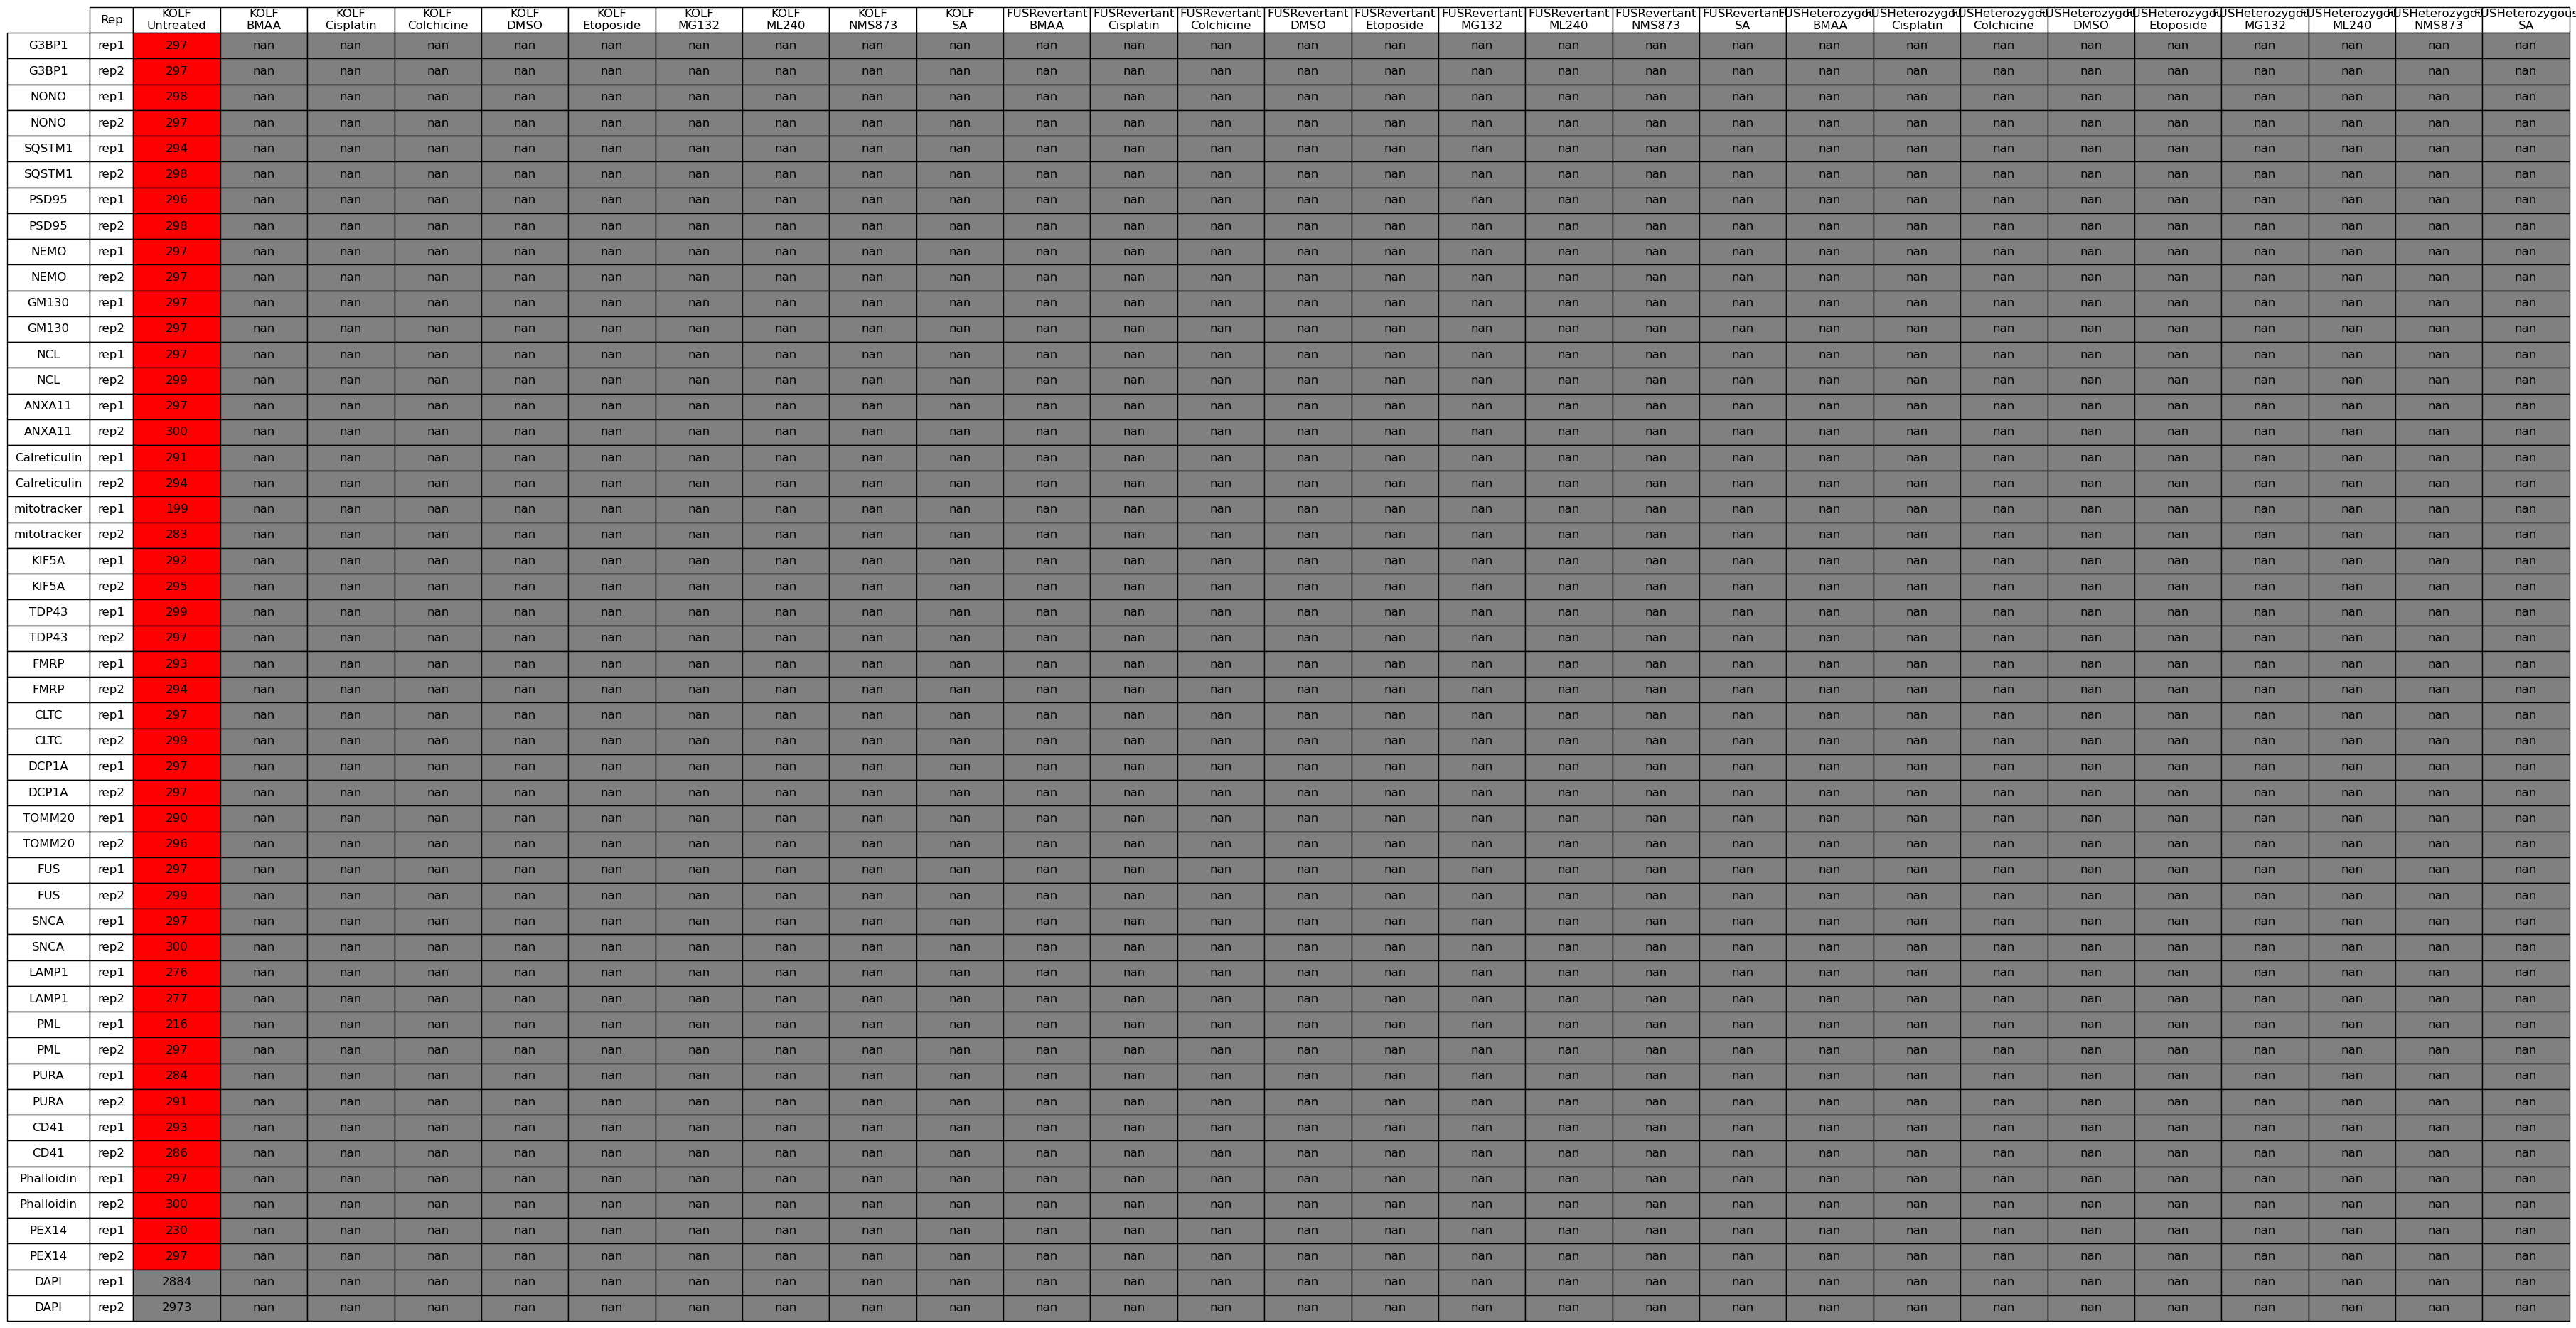

In [19]:
root_directory_proc = os.path.join(MOMAPS_DATA_HOME, 'input', 'images', 'processed', 'spd2',
                              'SpinningDisk','FUS_lines_stress_2024_sorted')
procs = run_validate_folder_structure(root_directory_proc, True, fus_panels, fus_markers,PLOT_PATH,fus_marker_info,
                                    fus_cell_lines_to_cond, reps, fus_cell_lines_for_disp, fus_expected_dapi_raw,
                                     batches=batches, fig_width=15)

### Difference between Raw and Processed

In [ ]:
display_diff(batches, raws, procs, PLOT_PATH, fig_width=15)

## Variance in each batch

In [ ]:
#for batch in list(range(3,9)) + ['7_16bit','8_16bit','9_16bit']:  

for batch in batches:
    with contextlib.redirect_stdout(io.StringIO()):
        var = sample_and_calc_variance(root_directory_proc, batch, 
                                       sample_size_per_markers=200, cond_count=2, rep_count=len(reps), 
                                       num_markers=len(dnls_markers))
    print(f'{batch} var: ',var)

# filtering qc
By order of filtering

## 1. % site survival after Brenner on DAPI channel
Percentage out of the total sites

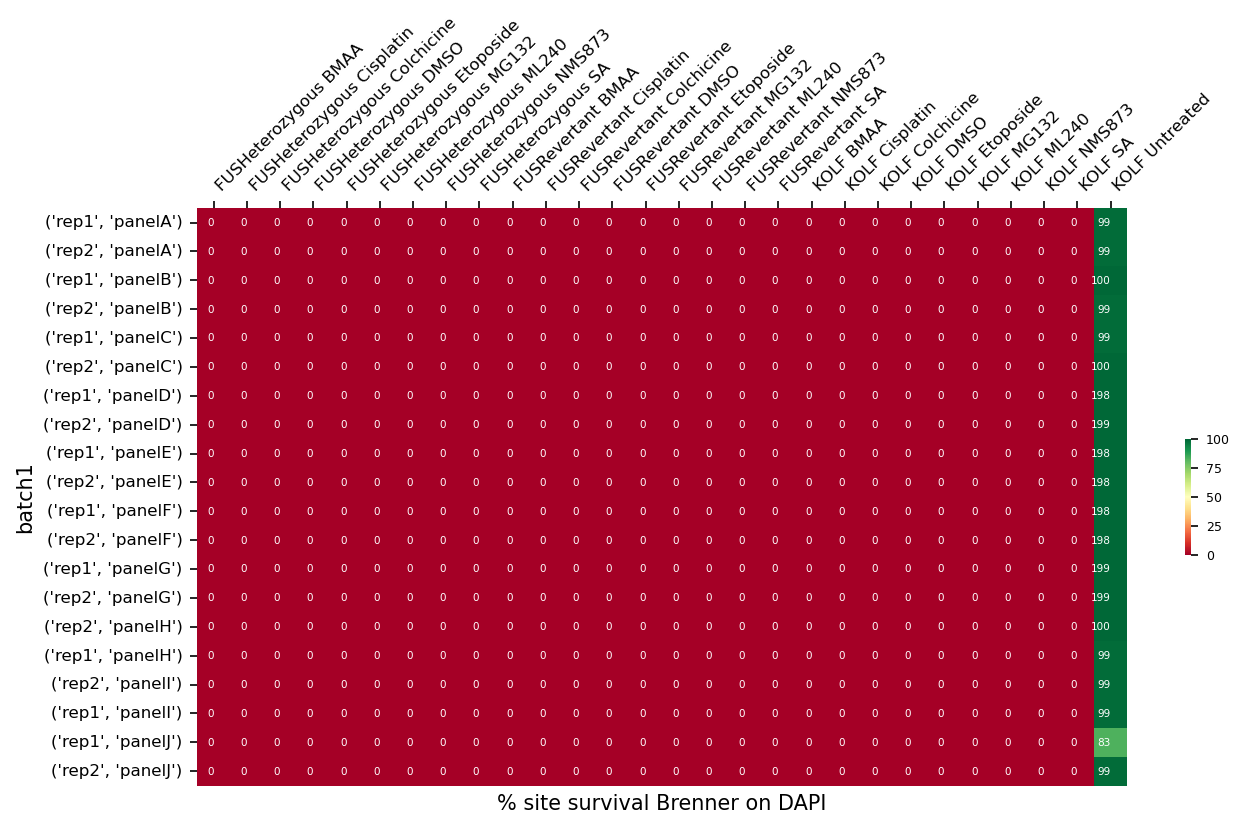

In [24]:
dapi_filter_by_brenner = show_site_survival_dapi_brenner(df_dapi,batches, fus_line_colors, fus_panels,
                                                        figsize=(10,5))

## 2. % Site survival after Cellpose
Percentage out of the sites that passed the previous filter. In parenthesis are absolute values.

**A site will be filtered out if Cellpose found 0 cells in it.**

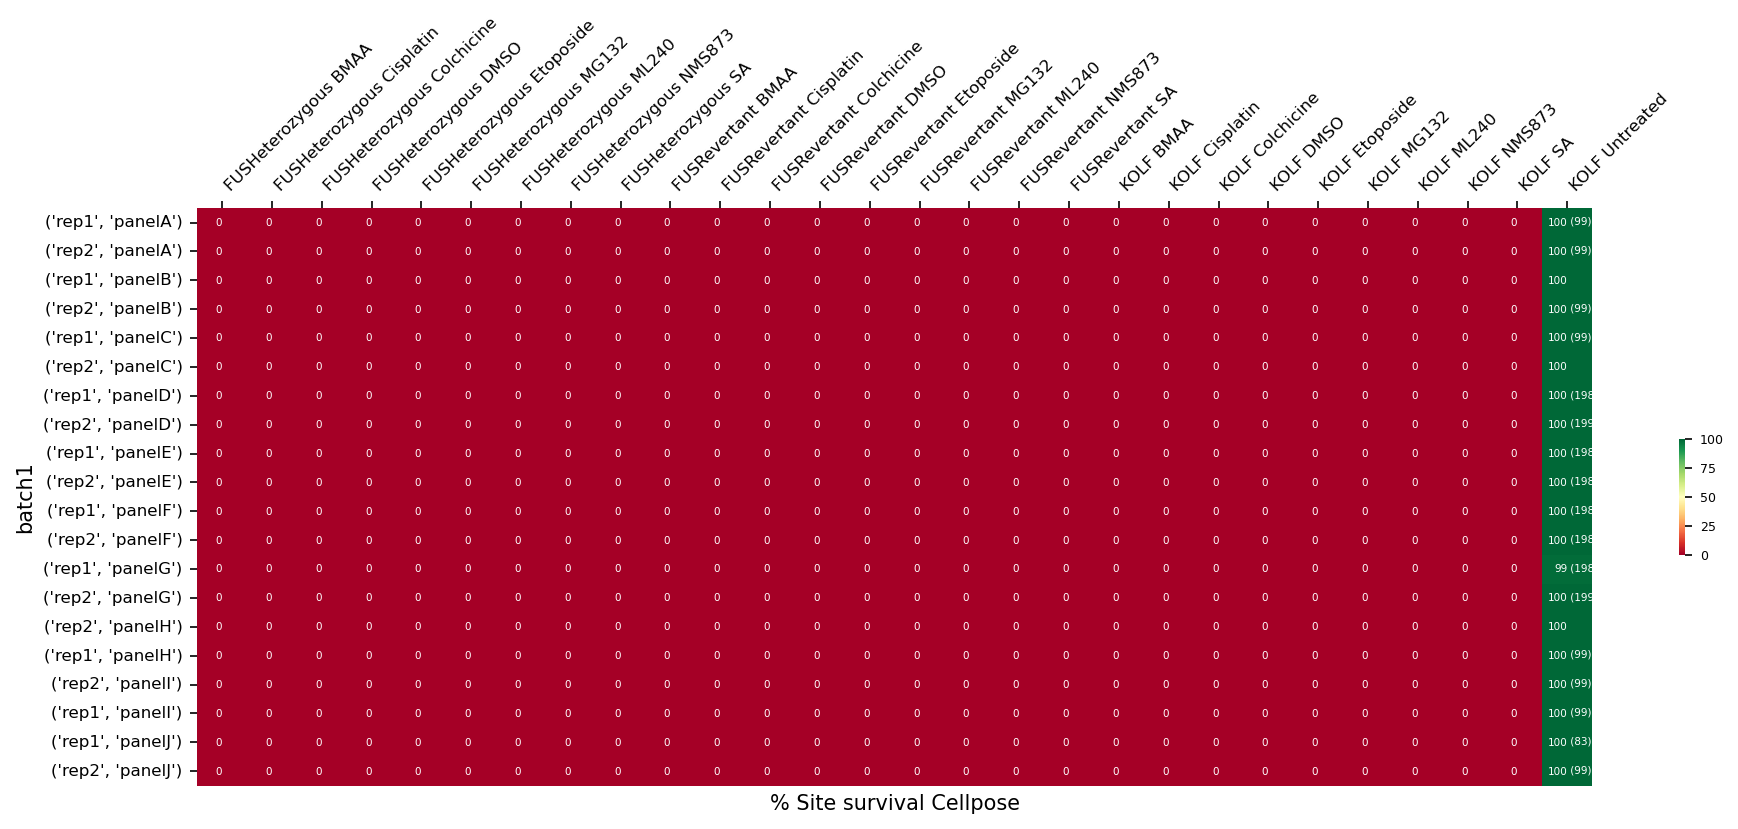

In [25]:
dapi_filter_by_cellpose = show_site_survival_dapi_cellpose(df_dapi, batches, dapi_filter_by_brenner, 
                                                           fus_line_colors, fus_panels, figsize=(15,5))

## 3. % Site survival by tiling
Percentage out of the sites that passed the previous filter. In parenthesis are absolute values.

**A site will be filtered out if after tiling, no tile is containing at least 85% of a cell that Cellpose detected.**

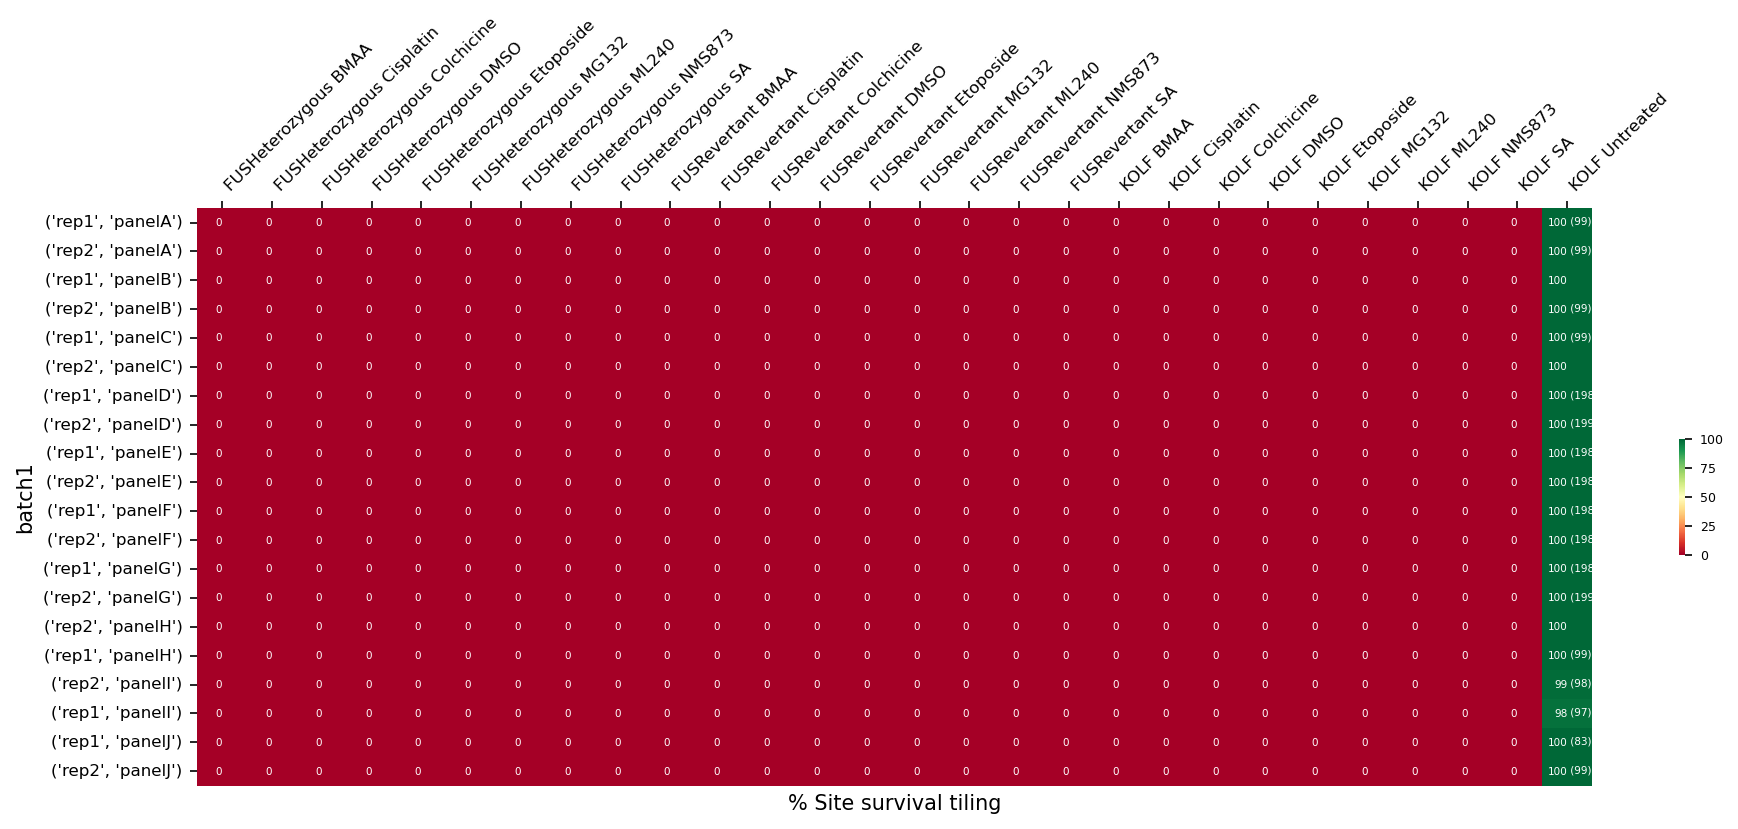

In [26]:
dapi_filter_by_tiling=show_site_survival_dapi_tiling(df_dapi, batches, dapi_filter_by_cellpose, 
                                                     fus_line_colors, fus_panels, figsize=(15,5))

## 4. % Site survival after Brenner on target channel
Percentage out of the sites that passed the previous filter. In parenthesis are absolute values (if different than the percentages).

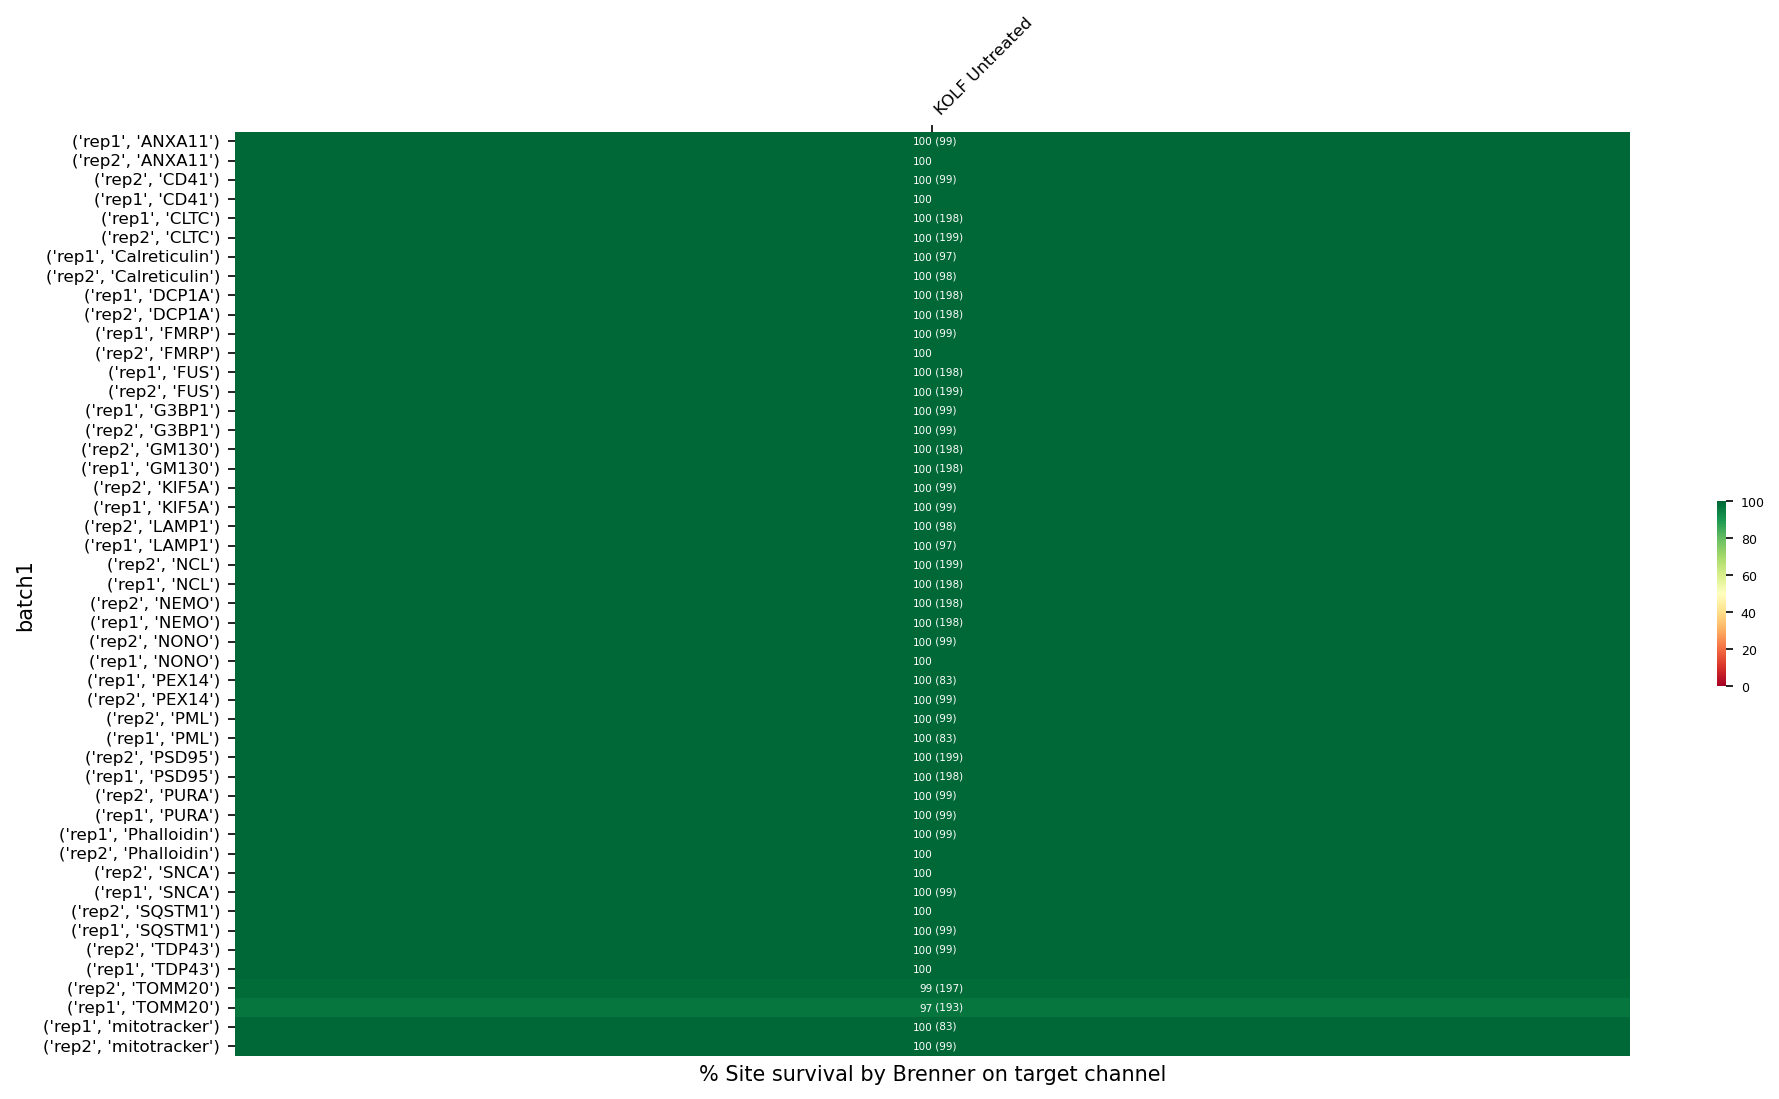

In [27]:
show_site_survival_target_brenner(df_dapi, df_target, dapi_filter_by_tiling,
                                 figsize=(15,8), markers=fus_markers)

### Numbers!

1. Total number of tiles: for each condition, we can know how many **tiles** we have --> number of data points for the model to train and infer on --> number of points in UMAPs..
2. Total number of whole cells: for each condtion, we can know how many **whole cells** we have

In [ ]:
names = ['Total number of tiles', 'Total number of whole cells']
stats = ['n_valid_tiles','site_whole_cells_counts_sum','site_cell_count','site_cell_count_sum']
total_sum = calc_total_sums(df_target, df_dapi, stats)
    

# for stat, name in zip(stats[:2], names):
#     to_heatmap = total_sum.rename(columns={stat:'index'})
#     plot_filtering_heatmap(to_heatmap, extra_index='marker', vmin=None, vmax=None,
#                           xlabel = name, show_sum=True, figsize=(4,8))

In [ ]:
total_sum.sum()

In [ ]:
show_total_sum_tables(total_sum)

# <font color='red'>Number of Cells in Site for each batch and cell line</font>

In [ ]:
df_no_empty_sites = df_dapi[df_dapi.n_valid_tiles !=0]
plot_cell_count(df_no_empty_sites, fus_lines_order, fus_custom_palette, y='site_cell_count_sum', 
                title='Cell Count Average per Site (from tiles)')

plot_cell_count(df_no_empty_sites, fus_lines_order, fus_custom_palette, y='site_whole_cells_counts_sum',
                title='Whole Cell Count Average per Site')

plot_cell_count(df_no_empty_sites, fus_lines_order, fus_custom_palette, y='site_cell_count',
               title='Cellpose Cell Count Average per Site')


# <font color='blue'>number of valid tiles per image (site)</font>


In [ ]:
plot_catplot(df_dapi, fus_custom_palette,reps, x='n_valid_tiles', x_title='valid tiles count', batch_min=1, batch_max=1)


## <font color='purple'>Heatmap QC per batch, panel and cell line(tiles that passed QC condition)  </font>


In [ ]:
plot_hm(df_dapi, split_by='rep', rows='cell_line_cond', columns='panel')

# Assessing Staining Reproducibility and Outliers

In [ ]:
for batch in batches:
    print(batch)
    #batch_num = batch.replace('batch',"")
    run_calc_hist_new(f'FUS_lines_stress_2024_sorted/{batch}', fus_cell_lines_for_disp, fus_markers, 
                           hist_sample=10,sample_size_per_markers=200, ncols=8, nrows=4, dnls=True)
    print("="*30)

In [ ]:
# save notebook as HTML ( the HTML will be saved in the same folder the original script is)
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();'))
os.system('jupyter nbconvert --to html src/preprocessing/notebooks/no_ds/qc_report_newPP_dNLS.ipynb')